













































































































































'










# Packages Installs, imports, and presets

In [4]:
#from scapy.all import *
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
import os
from transformers import MobileViTV2Model, MobileViTV2Config
import torch
import torchmetrics
from torch import optim
import lightning as L
import torch
import torch.nn as nn

In [5]:
from lightning.pytorch.loggers import WandbLogger
import wandb
wandb.init() 

wandb: Currently logged in as: heitorwerneck (heitor57). Use `wandb login --relogin` to force relogin


In [6]:
INPUT_SIZE = (256,256,3)

## Removing missing features

In [7]:
df_train= pd.read_parquet('data/iec104_train.parquet')
df_validation = pd.read_parquet('data/iec104_validation.parquet')
df_test=pd.read_parquet('data/iec104_test.parquet')

In [8]:
missing_features=[c for c,v in ((df_train==-1).sum() == len(df_train)).items() if v==True]

In [9]:
missing_features.extend(df_train.filter(regex='payload*',axis=1).columns)

In [10]:
df_train=df_train.drop(missing_features,axis=1)
df_test=df_test.drop(missing_features,axis=1)
df_validation=df_validation.drop(missing_features,axis=1)

In [11]:
df_train.shape

(319038, 419)

In [12]:
len(set(df_train.index))

30756

In [13]:
display(df_train['label'].value_counts())
display(df_validation['label'].value_counts())
display(df_test['label'].value_counts())

label
1     243295
3      12729
7      12658
6      10702
4       7241
5       7153
0       6902
10      5876
8       4632
9       4466
2       3384
Name: count, dtype: int64

label
1     77307
7      3096
3      3013
6      2522
5      1855
0      1769
4      1748
10     1361
8      1194
9      1112
2       930
Name: count, dtype: int64

label
1     60019
3      4252
7      3883
6      3327
0      2292
4      2224
5      2090
10     1882
9      1377
8      1360
2      1029
Name: count, dtype: int64

In [14]:
# # del df_train_initial
# del df

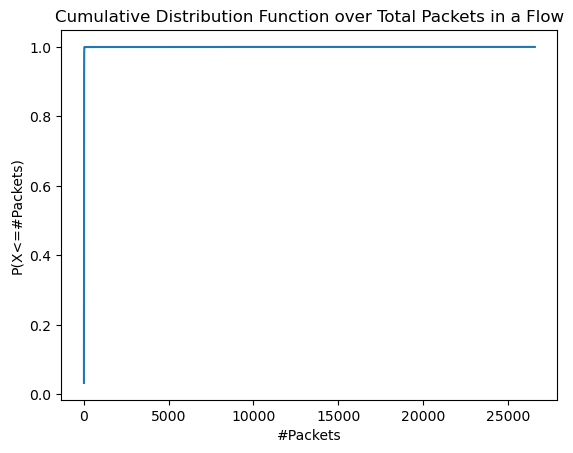

In [15]:
# df_test.groupby('flow').

def plot_cdf(x):
  plt.title('Cumulative Distribution Function over Total Packets in a Flow')
  plt.xlabel("#Packets")
  plt.ylabel(r"P(X<=#Packets)")
  # print(x)
  plt.plot(x)
tmp=df_train.groupby('flow')['tv_sec'].count().value_counts()
tmp=tmp.sort_index().cumsum()
tmp = tmp/tmp.max()
plot_cdf(tmp)

In [16]:
tmp=df_train.groupby('flow')['tv_sec'].count().value_counts()
tmp=tmp.sort_index().cumsum()
# tmp = tmp/tmp.max()
tmp

tv_sec
1         1015
2         7305
3         7685
4         8080
5         8331
6        13365
7        15748
8        20172
9        22194
10       26821
11       28692
12       28971
13       29454
14       29692
15       30154
16       30283
17       30415
18       30454
19       30475
20       30494
21       30582
22       30602
23       30612
24       30622
25       30711
26       30716
27       30742
29       30743
30       30744
31       30745
483      30746
549      30747
571      30748
7591     30749
7621     30750
8014     30751
8262     30752
8562     30753
8808     30754
25497    30755
26601    30756
Name: count, dtype: int64

In [17]:
# TRAIN_SIZE = 0.7
# tmp = random.shuffle(list(set(df_train.index)))
# TRAIN_SAMPLES = int(len(df_train)*TRAIN_SIZE)
# df_train,df_validation = df_train.iloc[:TRAIN_SAMPLES],df_train.iloc[TRAIN_SAMPLES:]

In [18]:
assert df_train.groupby(df_train.index)['label'].nunique().max()==1

In [19]:
df_train

,tv_sec,tv_usec,ipv4_ver_0,ipv4_ver_1,ipv4_ver_2,ipv4_ver_3,ipv4_hl_0,ipv4_hl_1,ipv4_hl_2,ipv4_hl_3,...,tcp_opt_87,tcp_opt_88,tcp_opt_89,tcp_opt_90,tcp_opt_91,tcp_opt_92,tcp_opt_93,tcp_opt_94,tcp_opt_95,label
flow,,,,,,,,,,,,,,,,,,,,,
1_192.168.1.28_192.168.1.24_43067_2404_TCP_c_rp_na_1_DoS_c_rp_na_1_DoS,1591456207,412188,0,1,0,0,0,1,0,1,...,1,0,1,0,1,0,0,1,1,7
1_192.168.1.28_192.168.1.24_43067_2404_TCP_c_rp_na_1_DoS_c_rp_na_1_DoS,1591456207,420146,0,1,0,0,0,1,0,1,...,0,0,0,1,1,1,1,1,1,7
1_192.168.1.28_192.168.1.24_43067_2404_TCP_c_rp_na_1_DoS_c_rp_na_1_DoS,1591456217,435642,0,1,0,0,0,1,0,1,...,1,0,1,0,1,0,0,1,1,7
1_192.168.1.28_192.168.1.24_43067_2404_TCP_c_rp_na_1_DoS_c_rp_na_1_DoS,1591456217,443262,0,1,0,0,0,1,0,1,...,1,0,1,1,0,0,1,1,0,7
1_192.168.1.28_192.168.1.24_43067_2404_TCP_c_rp_na_1_DoS_c_rp_na_1_DoS,1591456217,583819,0,1,0,0,0,1,0,1,...,1,0,1,1,0,1,1,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_192.168.1.29_192.168.1.19_46341_2404_TCP_c_sc_na_1_c_sc_na_1,1588103130,199354,0,1,0,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,9
1_192.168.1.29_192.168.1.19_46341_2404_TCP_c_sc_na_1_c_sc_na_1,1588103131,129817,0,1,0,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,9
1_192.168.1.29_192.168.1.19_46341_2404_TCP_c_sc_na_1_c_sc_na_1,1588103132,84195,0,1,0,0,0,1,0,1,...,0,1,1,1,1,1,0,0,0,9


#### Static vs Dynamic Packet (w.r.t. Flow) Features

In [20]:
# pat = '([\w\d_]+)_?\d*'
# pat=r"([\w_]+)_\d*"
pat=r"([\w_]+)_\d+"
tmp=df_train.iloc[:20000, df_train.columns != 'label'].T.reset_index().replace(to_replace=pat, value=r"\1", regex=True).groupby('index').agg(lambda x: ''.join(map(str,x))).T
tmp = tmp.groupby(tmp.index).nunique().max().to_frame().sort_values(by=0,ascending=False)

In [21]:
static_features= set(tmp.loc[tmp[0]==1].index)
dynamic_features = set(tmp.index) - static_features

In [22]:
dynamic_features_raw = {'tcp_opt','tv_sec','tv_usec','tcp_cksum','tcp_ackn','tcp_seq','ipv4_tl'}
dynamic_features_reduce =  dynamic_features - dynamic_features_raw

In [23]:
dynamic_features_raw,dynamic_features_reduce,static_features = list(dynamic_features_raw),list(dynamic_features_reduce),list(static_features)
dynamic_features=  list(dynamic_features)

In [24]:
# dynamic_features.insert(0,'ipv4_src')
# dynamic_features.insert(0,'ipv4_dst')

# static_features.remove('ipv4_src')
# static_features.remove('ipv4_dst')

# dynamic_features.insert(0,'tcp_sprt')
# dynamic_features.insert(0,'tcp_dprt')

# static_features.remove('tcp_sprt')
# static_features.remove('tcp_dprt')


In [25]:
# [i for i in df_train.columns if len([for i in dynamic_features]) > 0]
def get_bit_columns(features):
  dynamic_features_bit_columns= []
  for column_name in df_train.columns:
    for feature_name in features:
      if  feature_name in column_name:
        dynamic_features_bit_columns.append(column_name)
        break
  return dynamic_features_bit_columns

In [26]:
dynamic_features_bit_columns= get_bit_columns(dynamic_features)
static_features_bit_columns= get_bit_columns(static_features)

In [27]:
static_features

['ipv4_hl',
 'tcp_rst',
 'tcp_ns',
 'tcp_ece',
 'tcp_urg',
 'ipv4_dfbit',
 'tcp_ackf',
 'tcp_cwr',
 'ipv4_rbit',
 'ipv4_proto',
 'tcp_psh',
 'tcp_urp',
 'tcp_fin',
 'tcp_doff',
 'ipv4_mfbit',
 'ipv4_foff',
 'ipv4_tos',
 'tcp_syn',
 'ipv4_ver',
 'tcp_res']

In [28]:
dynamic_features

['ipv4_src',
 'tv_sec',
 'tv_usec',
 'ipv4_tl',
 'tcp_sprt',
 'tcp_opt',
 'tcp_wsize',
 'ipv4_id',
 'ipv4_ttl',
 'ipv4_dst',
 'tcp_seq',
 'tcp_ackn',
 'ipv4_cksum',
 'tcp_cksum',
 'tcp_dprt']

In [29]:
# df_train.loc[:, dynamic_features_bit_columns]

In [30]:
num_dynamic_features = len(dynamic_features_bit_columns)
num_static_features= len(static_features_bit_columns)
num_dynamic_features, num_static_features

(346, 72)

In [31]:
len(set(df_train.index))

30756

In [32]:
NUM_FEATURES = df_train.shape[1]-1

## Training Dataset

In [33]:
import torch.utils.data as data_utils
import torch.nn.functional as F
from torch.utils.data import Dataset
SEQ_LEN = 10
BATCH_SIZE=48

class IEC104Dataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.flow_int_id = list(set(self.df.index))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.flow_int_id)

    def __getitem__(self, idx):
        df_idx = self.flow_int_id[idx]
        flow = self.df.loc[df_idx, self.df.columns != 'label']
        label = self.df.loc[df_idx, 'label']

        if isinstance(flow, pd.Series):
            flow = flow.to_frame().T

        if not isinstance(label, np.int64):
            label = label.iloc[0]
        label = torch.tensor(label)

        if self.transform:
            flow = self.transform(flow)
        if self.target_transform:
            label = self.target_transform(label)
        # print(flow)
        # print(label)
        return flow, label

def feature_transform(flow):
    # start_time = time.time()
    # Convert flow to a DataFrame if it's not already
    flow = pd.DataFrame(flow)

    # Extract dynamic and static features
    # dynamic_features = flow.loc[:, dynamic_features_bit_columns].values
    # static_features = flow.loc[:, static_features_bit_columns].iloc[0].values
    
    # Convert to tensors
    
    dynamic_tensor = torch.tensor(flow.values, dtype=torch.float32)
    # static_tensor = torch.tensor(static_features, dtype=torch.float32)
    
    # X = -torch.ones(SEQ_LEN, dynamic_tensor.shape[1], dtype=torch.float32)
    X = -torch.ones(SEQ_LEN, dynamic_tensor.shape[1], dtype=torch.float32)
    min_shape_0 = min(dynamic_tensor.shape[0], SEQ_LEN)
    X[:min_shape_0] = dynamic_tensor[-min_shape_0:]

    X = (X+1)/2
    return X
    # return dynamic_tensor
NUM_WORKERS =6
PREFETCH_FACTOR=2
train_dataset = IEC104Dataset(df_train,transform = feature_transform)
validation_dataset = IEC104Dataset(df_validation,transform = feature_transform)
test_dataset = IEC104Dataset(df_test,transform = feature_transform)


### Dataset Loader

In [34]:
import torch.nn.utils.rnn

In [35]:
# def collate_fn(batch):
#     sequences, labels = zip(*batch)
    
#     # Determine the lengths of each sequence
#     # lengths = [len(seq) for seq in sequences]
    
#     # Sort the sequences and labels by lengths in descending order
#     # sorted_indices = sorted(range(len(lengths)), key=lambda i: lengths[i], reverse=True)
#     # sorted_sequences = [sequences[i] for i in sorted_indices]
#     # sorted_labels = [labels[i] for i in sorted_indices]
    
#     # Convert lists to tensors
#     sorted_sequences = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True,padding_value=-1)
#     sorted_labels = torch.stack(labels)
    
#     # Pack the padded sequences
#     # packed_sequences = torch.nn.utils.rnn.pack_padded_sequence(sorted_sequences, lengths, batch_first=True, enforce_sorted=False)
    
#     return sorted_sequences, sorted_labels



In [36]:


class_sample_output=df_train.reset_index().groupby('label')['flow'].nunique().tolist()
print(class_sample_output)
sampling_weights = 1 / torch.Tensor(class_sample_output)
print(sampling_weights)

labels = train_dataset.df.groupby('flow')['label'].unique()
labels=[labels.loc[i][0] for i in train_dataset.flow_int_id]
samples_weight = np.array([sampling_weights[t] for t in labels]).flatten()

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
print(samples_weigth)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))


# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR,sampler = sampler)#,collate_fn = collate_fn)
# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
next(iter(train_loader))

validation_loader = data_utils.DataLoader(dataset = validation_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)
test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)

# next(iter(train_loader))

[919, 19968, 680, 1582, 914, 1196, 1218, 1573, 720, 987, 999]
tensor([1.0881e-03, 5.0080e-05, 1.4706e-03, 6.3211e-04, 1.0941e-03, 8.3612e-04,
        8.2102e-04, 6.3573e-04, 1.3889e-03, 1.0132e-03, 1.0010e-03])
tensor([5.0080e-05, 5.0080e-05, 5.0080e-05,  ..., 5.0080e-05, 5.0080e-05,
        8.2102e-04], dtype=torch.float64)


In [37]:
b = next(iter(test_loader))

## Model Design

In [38]:
# model_vitv2_output_shape = [ 512, 8, 8]
NUM_CLASSES = df_train.label.nunique()

In [39]:
def get_device():
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda"
    return device
DEVICE = get_device()

In [40]:
import seaborn as sns

In [41]:
import wandb

### Lightning

In [42]:


class LFVIT(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.step_outputs = []
        self.step_target = []
    def forward(self, inputs):
        return self.model(inputs)
    def training_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        loss = nn.functional.cross_entropy(target_prediction, y)
        # self.step_outputs.append(target_prediction)
        # self.step_target.append(y)
        self.log('train_loss',loss,on_epoch=True,on_step=False)
        return loss
        # metrics = self._shared_eval_step(batch, batch_idx,step_type='train')
        # for key,value in metrics.copy().items():
        #     metrics["train_"+key]=metrics.pop(key)
        # self.log_dict(metrics,prog_bar=True,on_step=False, on_epoch=True)
        # return metrics['train_loss']
    def validation_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        self.step_outputs.append(target_prediction)
        self.step_target.append(y)
        loss = nn.functional.cross_entropy(target_prediction, y)
        self.log('val_loss',loss,on_epoch=True,on_step=False)
        # loss = nn.functional.cross_entropy(target_prediction, y)
        # self.log('val_loss',loss)
    def test_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        self.step_outputs.append(target_prediction)
        self.step_target.append(y)        
    # def on_test_epoch_end(self):
    def on_test_epoch_end(self):
        self._shared_on_epoch_end(end_type='test')
    def on_validation_epoch_end(self):
        self._shared_on_epoch_end('validation')
    def _shared_on_epoch_end(self,end_type):
        all_preds = torch.cat(self.step_outputs)
        all_targets = torch.cat(self.step_target)
        # all_preds=torch.flatten(all_preds,start_dim=0,end_dim=1)
        # all_targets=torch.flatten(all_targets,start_dim=0,end_dim=1)
        # print(all_preds[:])
        # print(all_targets.shape)
        # print(all_preds.shape)
        print(all_targets[:5])
        print(all_preds[:5])
        metrics = dict()
        suffix= end_type+'_'
        # print(all_preds.shape)
        # print(all_targets.shape)        
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        metrics[suffix+'accuracy'] = accuracy(all_preds, all_targets)
        
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES,average='macro').to(DEVICE)
        metrics[suffix+'accuracy_macro'] = accuracy(all_preds, all_targets)

        confusionmatrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        confusionmatrix_result = confusionmatrix(all_preds, all_targets).cpu().numpy()
        df_cm = pd.DataFrame(confusionmatrix_result, index = range(NUM_CLASSES), columns=range(NUM_CLASSES))
        
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        fig_.savefig('tmp/confusionmatrix.png')
        wandb_logger.log_image(key=suffix+"confusionmatrix", images=['tmp/confusionmatrix.png'])
        
        confusionmatrix = torchmetrics.ConfusionMatrix(normalize='true',task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        confusionmatrix_result = confusionmatrix(all_preds, all_targets).cpu().numpy()
        df_cm = pd.DataFrame(confusionmatrix_result, index = range(NUM_CLASSES), columns=range(NUM_CLASSES))
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        fig_.savefig('tmp/confusionmatrix_normalized.png')
        wandb_logger.log_image(key=suffix+"confusionmatrix_normalized", images=['tmp/confusionmatrix_normalized.png'])
        
        self.log_dict(metrics)
        self.step_outputs.clear()
        self.step_target.clear()
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')
        return {'optimizer':optimizer,"lr_scheduler":{"scheduler": scheduler, "interval": "epoch","frequency": 1,"monitor": "val_loss"}}


In [43]:

# accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)

# accuracy(torch.tensor(4, device='cuda:0'),
# torch.tensor([0.0824, 0.0977, 0.1032, 0.0896, 0.0766, 0.1045, 0.0956, 0.0752, 0.0876,
#         0.0868, 0.1010], device='cuda:0'))

###  FVIT


In [44]:
import math

class FVIT(nn.Module):
    def __init__(self,encoder,decoder):
        super(FVIT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        hidden_states=self.encoder(x[0])
        concatenated_input = torch.cat((torch.flatten(hidden_states, start_dim=1), torch.flatten(x[1], start_dim=1)),dim=1)
        return self.decoder(concatenated_input)
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        # print(x.shape)
        x = x + self.pe[:, :x.size(1), :]  # Shape: (batch_size, seq_len, d_model)
        return x

class TransformerModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model,SEQ_LEN)
        print(d_model,nhead,dropout,nhid)
        self.transformer_encoder = nn.TransformerEncoder(
                        nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout,dim_feedforward=nhid,activation=nn.ReLU(),batch_first=True),
                num_layers=nlayers,norm=nn.LayerNorm(normalized_shape=NUM_FEATURES)
                )
        self.d_model = d_model
        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(NUM_FEATURES*SEQ_LEN, NUM_CLASSES),
            # nn.Dropout(0.5),
            # nn.ReLU(),
            # nn.Linear(100, NUM_CLASSES),
            nn.Softmax(dim=1)
)   
    # def init_weights(self):
    #     initrange = 0.1
    #     self.transformer_encoder.bias.data.zero_()
    #     self.transformer_encoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, x):
        # print('fow',x.shape)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        # print(x.shape)
        # print("DD:",x)
        x= self.decoder(x)
        # return output
        return x

In [45]:
output_dim_transformer_encoder = [SEQ_LEN,SEQ_LEN,NUM_FEATURES]

In [46]:
NUM_FEATURES

418

In [47]:
from x_transformers import Encoder


In [48]:
# model_vitv2 = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
# model_vitv2 = MobileViTV2Model(config=MobileViTV2Config())
# d_model+num_static_features, num_classes


# D_MODEL = num_dynamic_features


# decoder=nn.Sequential(
#     # nn.Flatten(),
#     # nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, 1500),
#     # nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, NUM_CLASSES),
#     nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, 100),
#     nn.ReLU(),
#     nn.Linear(100, NUM_CLASSES),
#     nn.Softmax(dim=1)
# )

# model_fvit = LFVIT(TransformerModel(d_model=NUM_FEATURES, nhead=2, nhid=2048, nlayers=4, dropout=0))
model_fvit = LFVIT(nn.Sequential(
    Encoder(dim = NUM_FEATURES,
        depth = 6,
        heads = 11),
            nn.Flatten(),
            nn.Linear(NUM_FEATURES*SEQ_LEN, 100),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(100, NUM_CLASSES),
            
            nn.Softmax(dim=1)
))

In [49]:
model_fvit.model

Sequential(
  (0): Encoder(
    (layers): ModuleList(
      (0): ModuleList(
        (0): ModuleList(
          (0): LayerNorm((418,), eps=1e-05, elementwise_affine=True)
          (1-2): 2 x None
        )
        (1): Attention(
          (to_q): Linear(in_features=418, out_features=704, bias=False)
          (to_k): Linear(in_features=418, out_features=704, bias=False)
          (to_v): Linear(in_features=418, out_features=704, bias=False)
          (attend): Attend(
            (attn_dropout): Dropout(p=0.0, inplace=False)
          )
          (to_out): Linear(in_features=704, out_features=418, bias=False)
        )
        (2): Residual()
      )
      (1): ModuleList(
        (0): ModuleList(
          (0): LayerNorm((418,), eps=1e-05, elementwise_affine=True)
          (1-2): 2 x None
        )
        (1): FeedForward(
          (ff): Sequential(
            (0): Sequential(
              (0): Linear(in_features=418, out_features=1672, bias=True)
              (1): GELU(approx

In [50]:
# model_vitv2 = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
# # model_vitv2 = MobileViTV2Model(config=MobileViTV2Config())
# # d_model+num_static_features, num_classes


# # D_MODEL = num_dynamic_features


# decoder=nn.Sequential(
#     # nn.Flatten(),
#     # nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, 1500),
#     # nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, NUM_CLASSES),
#     nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, 100),
#     nn.ReLU(),
#     # nn.Dropout(dropout),
#     # nn.Linear(1500, 100),
#     # nn.LeakyReLU(),
#     # nn.Dropout(dropout),
#     nn.Linear(100, NUM_CLASSES),
#     nn.Softmax(dim=1)
# )
# transformer_encoder = TransformerModel(d_model=num_dynamic_features, nhead=6, nhid=2048, nlayers=3, dropout=0.01)

# fvit = FVIT(transformer_encoder,decoder)
# model_fvit = LFVIT(fvit)

## Running


In [51]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all")

MAX_EPOCHS=200
# timer =  L.pytorch.calalbacks.Timer()
def run_fvit_trainer_fit(train_loader,validation_loader,model):
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        monitor='train_loss',
        filename='iec104-{epoch:02d}-{loss}',
        save_top_k=0,
        mode='min', 
    )

    # early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
    # cpb=CustomProgressBar()
    trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback],accelerator=DEVICE,
                        devices=1,log_every_n_steps=20
                        #,check_val_every_n_epoch=1
                        # ,limit_train_batches=100,limit_val_batches=100#,max_time={"minutes": 60}
                        ,logger=wandb_logger)
    trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
    return checkpoint_callback,trainer
checkpoint_callback,trainer=run_fvit_trainer_fit(
    train_loader,
    validation_loader,
     model=model_fvit)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 15.9 M
-------------------------------------
15.9 M    Trainable params
0         Non-trainable params
15.9 M    Total params
63.546    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

tensor([1, 1, 1, 1, 1], device='cuda:0')
tensor([[0.1025, 0.0986, 0.0637, 0.0639, 0.1128, 0.0689, 0.0968, 0.0861, 0.1175,
         0.1239, 0.0651],
        [0.0833, 0.0821, 0.0697, 0.0708, 0.0964, 0.0924, 0.1021, 0.0885, 0.0939,
         0.1263, 0.0945],
        [0.1026, 0.0986, 0.0637, 0.0640, 0.1128, 0.0689, 0.0968, 0.0861, 0.1175,
         0.1239, 0.0651],
        [0.1025, 0.0986, 0.0637, 0.0639, 0.1128, 0.0689, 0.0969, 0.0861, 0.1175,
         0.1239, 0.0651],
        [0.0796, 0.1420, 0.0691, 0.0959, 0.0808, 0.0860, 0.0974, 0.0767, 0.0807,
         0.1321, 0.0596]], device='cuda:0')


/home/hwerneck/miniconda3/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 33 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |                                                                                                   …

Validation: |                                                                                                 …

tensor([1, 1, 1, 1, 1], device='cuda:0')
tensor([[1.2576e-02, 9.6334e-01, 4.1217e-05, 1.1476e-03, 1.7549e-02, 2.1441e-04,
         5.4145e-05, 3.9973e-03, 9.1427e-04, 1.6099e-04, 6.5089e-06],
        [1.4491e-02, 1.2057e-03, 2.6849e-04, 5.7421e-01, 2.3409e-02, 1.0219e-03,
         4.5823e-03, 3.7717e-01, 3.1664e-03, 1.3277e-04, 3.4256e-04],
        [1.2577e-02, 9.6334e-01, 4.1224e-05, 1.1476e-03, 1.7548e-02, 2.1440e-04,
         5.4141e-05, 3.9974e-03, 9.1429e-04, 1.6103e-04, 6.5092e-06],
        [1.2576e-02, 9.6334e-01, 4.1214e-05, 1.1476e-03, 1.7550e-02, 2.1440e-04,
         5.4148e-05, 3.9972e-03, 9.1427e-04, 1.6097e-04, 6.5086e-06],
        [7.1179e-05, 8.5751e-01, 2.9150e-02, 3.1506e-05, 8.5774e-05, 6.3408e-05,
         1.0102e-05, 3.4223e-05, 4.7168e-05, 1.1285e-01, 1.3868e-04]],
       device='cuda:0')


In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

ValueError: path must be a valid string

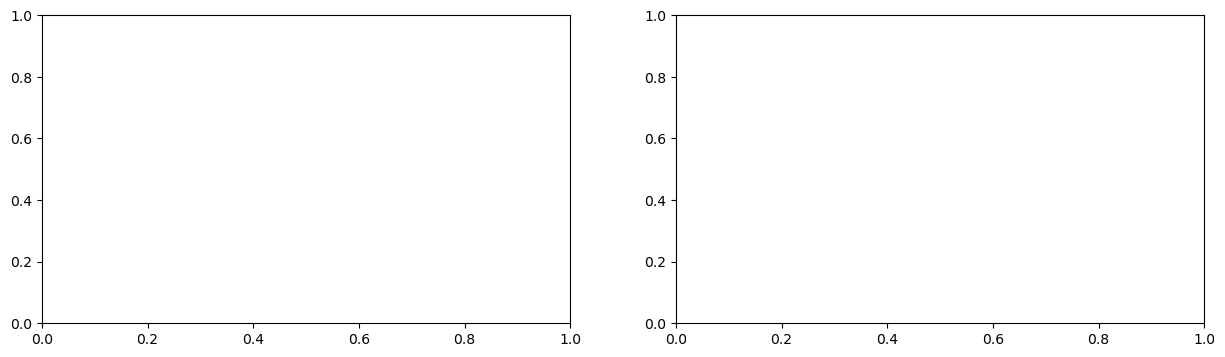

In [ ]:
def plot_training_metrics(trainer,metrics,ax):
    event_acc = EventAccumulator(trainer.logger.log_dir)
    event_acc.Reload()
    for i in range(len(metrics)):
        y=[i.value for i in event_acc.Scalars(metrics[i]['name'])]
        x=np.arange(len(y))+1
        ax[i].plot(x,y,marker='.')
        ax[i].set_xlabel("Epoch")
        ax[i].set_ylabel(metrics[i]['label'])
metrics=[{'name':'train_loss','label':'Training MSE Loss'},{'name':'val_loss','label':'Validation MSE Loss'}]
fig,ax = plt.subplots(ncols=len(metrics),figsize=(15,4))
plot_training_metrics(trainer,metrics,ax)

In [ ]:
metrics=[{'name':'train_accuracy','label':'Training Accuracy'},{'name':'val_accuracy','label':'Validation Accuracy'}]
fig,ax = plt.subplots(ncols=len(metrics),figsize=(15,4))
plot_training_metrics(trainer,metrics,ax)

In [ ]:
trainer.test(ckpt_path="best",dataloaders=test_loader)

In [ ]:
# class ImageFCN(nn.Module):
#     def __init__(self,fcn):
#         super(FVIT, self).__init__()
#         self.fcn = fcn

#     def forward(self, x):
#         return self.fcn(torch.flatten(x))
# ImageFCN(FullyConnectedNet())

In [ ]:
# MAX_EPOCHS=50
# # timer =  L.pytorch.calalbacks.Timer()
# def run_fvit_trainer_fit(train_loader,validation_loader,model):
#     checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
#         monitor='train_loss',
#         filename='iec104-{epoch:02d}-{loss:.2f}',
#         save_top_k=3,
#         mode='min',
#     )

#     early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
#     # cpb=CustomProgressBar()
#     trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback,early_stop_callback],accelerator=DEVICE,
#                         devices=1,log_every_n_steps=10,limit_train_batches=0.1,limit_val_batches=0.1,max_time={"minutes": 5})
#     trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
#     return checkpoint_callback,trainer
# checkpoint_callback,trainer=run_fvit_trainer_fit(
#     train_loader,
#     validation_loader,
#      model=model_fvit)

In [ ]:
class FVIT(nn.Module):
    def __init__(self,encoder,decoder):
        super(FVIT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        hidden_states=self.encoder(x[0]).last_hidden_state
        # print("Hidden states shape:", hidden_states.shape)
        # print("Additional input shape:", x[1].shape)
        # print("Concatenated input shape:", concatenated_input.shape)
        return self.decoder(hidden_states)
decoder= nn.Sequential(nn.Flatten(),
                       nn.Linear(512*8*8, NUM_CLASSES),
                         nn.Softmax(dim=1)
                   )
# model_fvit=FVIT(model_vitv2,decoder)

In [ ]:
fvit = FVIT(model_vitv2,decoder)
model_fvit = LFVIT(fvit)

In [ ]:
MAX_EPOCHS=50
# timer =  L.pytorch.calalbacks.Timer()
def run_fvit_trainer_fit(train_loader,validation_loader,model):
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        monitor='train_loss',
        filename='iec104-{epoch:02d}-{loss}',
        save_top_k=3,
        mode='min',
    )

    # early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
    # cpb=CustomProgressBar()
    trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback],accelerator=DEVICE,
                        devices=1,log_every_n_steps=10,limit_train_batches=0.1,limit_val_batches=0.1,max_time={"minutes": 5})
    trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
    return checkpoint_callback,trainer
checkpoint_callback,trainer=run_fvit_trainer_fit(
    train_loader,
    validation_loader,
     model=model_fvit)

In [ ]:
trainer.test(ckpt_path="best",dataloaders=test_loader)

In [ ]:
# class FVIT(nn.Module):
#     def __init__(self,encoder,decoder):
#         super(FVIT, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, x):
#         hidden_states=self.encoder(x[0]).last_hidden_state
#         # print("Hidden states shape:", hidden_states.shape)
#         # print("Additional input shape:", x[1].shape)
#         # print("Concatenated input shape:", concatenated_input.shape)
#         return self.decoder(hidden_states)
decoder= nn.Sequential(nn.Flatten(),
                       nn.Linear(512*8*8, 100),            nn.ReLU(),
                         
            nn.Linear(100, 50),
nn.Softmax(dim=1),
                   )
# model_fvit=FVIT(model_vitv2,decoder)